# Banking Fraud with various Predictions

## Setup

Import AWS specific modules and specify S3 data location

In [1]:
# ! pip install seaborn
# import sys
# !{sys.executable} -m pip install --upgrade seaborn
# !{sys.executable} -m pip install --upgrade imbalanced-learn
import boto3
import os
from random import seed, sample
import sagemaker
import sagemaker.amazon.amazon_estimator
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer

Import python ML modules

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_context("paper")

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
# from xgboost.sklearn import XGBClassifier

In [3]:
bucket = 'sagemaker-pmelvin'
prefix = 'compile_xgb_v3'
hp_prefix = 'hp_tuning_v3'

csv_data = 'input-data/bb_banking_fraud.csv'
csv_removed_types = 'input-data/removed-specific-types/01a89090-e9b6-4b07-8a49-b0244d6dc035.csv'
data_location = 's3://{}/{}'.format(bucket, csv_data)
#local_file = 'bb_banking_fraud.csv'

role = get_execution_role()
sess = sagemaker.Session()
smclient = boto3.Session().client('sagemaker')

## Data

In [4]:
%%time
df = pd.read_csv(data_location)

CPU times: user 10.5 s, sys: 2.42 s, total: 12.9 s
Wall time: 31.3 s


In [5]:
df.head(n=5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df_u = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest', 'isfraud':'isFraud'})

In [7]:
df_u.head(n=5)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
# df.shape

In [9]:
df_u_copy = df_u.copy()

df_u['hourOfDay'] = np.nan
df_u.hourOfDay = df_u_copy.step % 24

In [10]:
first_col = df_u.pop('isFraud')

In [11]:
df_u.insert(0, 'isFraud', first_col)

In [12]:
df_u.head(n=5)

,isFraud,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,hourOfDay
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,1
1,0,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,1
2,1,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,0,1
3,1,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0,1
4,0,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,1


In [13]:
counts = df_u['isFraud'].value_counts()
counts

0    6354407
1       8213
Name: isFraud, dtype: int64

In [14]:
counts / df_u.shape[0]

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [15]:
sample = df_u.sample(n=10000, random_state=42)

In [16]:
sample.head(n=5)

,isFraud,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,hourOfDay
3737323,0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,14
264914,0,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,15
85647,0,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,10
5899326,0,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,19
2544263,0,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,14


In [17]:
sample.isFraud.value_counts()

0    9981
1      19
Name: isFraud, dtype: int64

In [18]:
def get_features(df):
    
    selected_cols = [
        'type', 'amount', 'oldBalanceOrig', 'newBalanceOrig',
        'oldBalanceDest', 'newBalanceDest', 'isFraud', 'hourOfDay'
    ]
    
    df = df[selected_cols].copy()
    dummies = pd.get_dummies(df.type)
    df = pd.concat([df, dummies], axis=1).drop("type", axis=1)
    
    return df

In [19]:
def reduce_data(pca_df):
    pca_df = pca_df.copy()
    target = pca_df.pop("isFraud")
    scaler = StandardScaler()
    pca_df = scaler.fit_transform(pca_df)
    pca = PCA(n_components=2)
    components = pca.fit_transform(pca_df)

    comp_df = pd.DataFrame(components, columns=["X", "y"])
    target = target.reset_index(drop=True)
    plot_df = pd.concat([comp_df, target], axis=1)
    
    return plot_df

In [20]:
def fraud_plot(plot_df, maj_alpha=0.5, min_alpha=1, save=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.scatterplot(x="X", y="y", alpha=maj_alpha, data=plot_df[plot_df.isFraud == 0], label="Legitimate")
    sns.scatterplot(x="X", y="y", alpha=min_alpha, data=plot_df[plot_df.isFraud == 1], ax=ax, label="Fraud")
    plt.title("Legitimate vs Fraudulent Purchases")
    plt.tight_layout()
    if save != None:
        plt.savefig(save)
    plt.show()
    
    pass

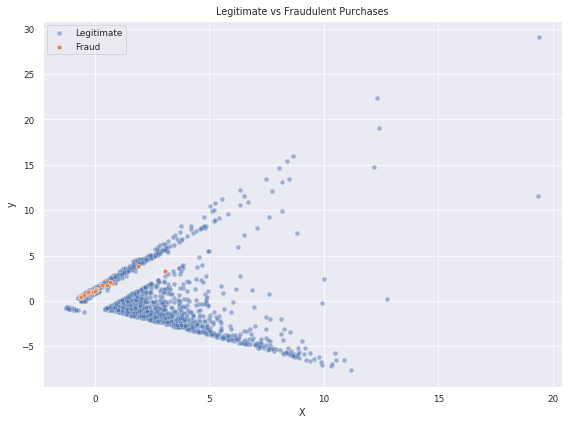

In [22]:
processed_data = get_features(sample)
plot_df = reduce_data(processed_data)
fraud_plot(plot_df)

In [ ]:
# processed_data.shape

In [ ]:
# processed_data.head(n=5)

In [23]:
from imblearn.under_sampling import RandomUnderSampler

In [24]:
RUS = RandomUnderSampler(sampling_strategy={0: 9589}, random_state=42)

In [25]:
def resample(df, method):
    processed_df = get_features(df)
    target = processed_df.pop('isFraud')

    processed_x, processed_y = method.fit_resample(processed_df, target)

    cols = list(processed_df.columns) + ["isFraud"]

    pdf_x = pd.DataFrame(processed_x, columns=processed_df.columns)
    pdf_y = pd.DataFrame(processed_y, columns=['isFraud'])
    resampled_df = pd.concat([pdf_x, pdf_y], axis=1)
    
    return resampled_df

In [26]:
%%time
rus_resampled = resample(df_u, RUS)
print(rus_resampled.shape)
print(rus_resampled.isFraud.value_counts())

(17802, 12)
0    9589
1    8213
Name: isFraud, dtype: int64


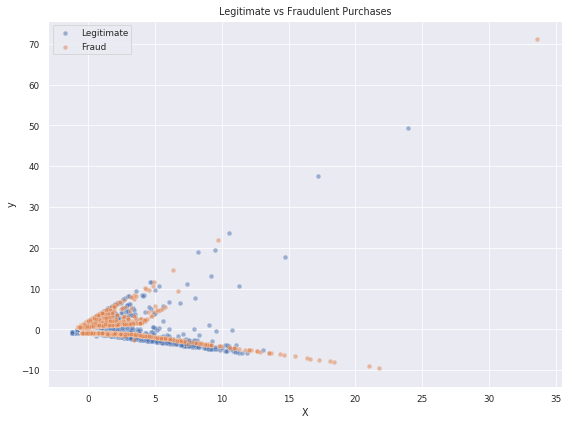

In [27]:
fraud_plot(reduce_data(rus_resampled), min_alpha=0.5)

In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
SM = SMOTE(random_state=42)

In [30]:
%%time
sm_resampled = resample(df_u, SM)
print(sm_resampled.shape)
print(sm_resampled.isFraud.value_counts())

(12708814, 12)
1    6354407
0    6354407
Name: isFraud, dtype: int64


In [31]:
sm_sample = sm_resampled.sample(n=10000, random_state=42)

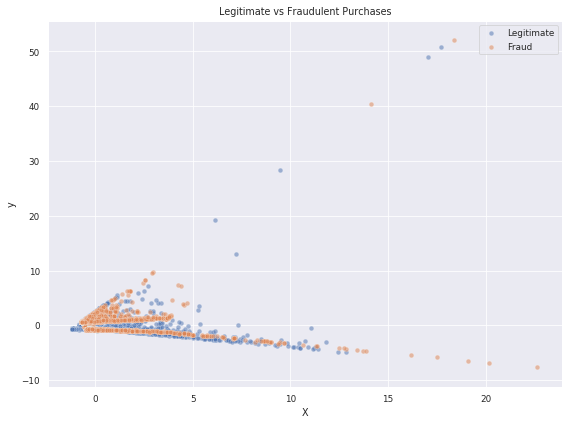

In [32]:
fraud_plot(reduce_data(sm_sample), min_alpha=0.5)


## Splitting and standardising

In [ ]:
# to allow reproducible splitting we define a RandomState and seed
# randomstate = 25
# seed(10)

In [33]:
first_col = rus_resampled.pop('isFraud')
rus_resampled.insert(0, 'isFraud', first_col)

In [34]:
X = rus_resampled.drop('isFraud', 1)
y = rus_resampled.isFraud

In [ ]:
# X.head(n=5)
# X.shape

In [ ]:
# y.head(n=5)
# y.shape

In [35]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state=42, shuffle=True, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42, shuffle=True, stratify=y) 

# print(X_train, X_val, X_test)

In [ ]:
# X_train, X_val, X_test = np.split(rus_resampled.sample(frac=1), [int(0.7 * len(rus_resampled)), int(0.9 * len(rus_resampled))])

In [36]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()

scaler.fit(X_train)

MinMaxScaler()

In [37]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [38]:
np.savetxt('train.csv', X_train, delimiter=',')
np.savetxt('test.csv', X_test, delimiter=',')
np.savetxt('validation.csv', X_val, delimiter=',')

In [ ]:
# X_train.to_csv('train.csv', header=False, index=False)
# X_test.to_csv('test.csv', header=False, index=False)
# X_val.to_csv('validation.csv', header=False, index=False)

In [73]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_train_location = 's3://{}/{}/train'.format(bucket, prefix)
print('Uploaded training data location: {}'.format(s3_train_location))

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_test_location = 's3://{}/{}/test'.format(bucket, prefix)
print('Uploaded test data location: {}'.format(s3_test_location))

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
s3_validation_location = 's3://{}/{}/validation'.format(bucket, prefix)
print('Uploaded validation data location: {}'.format(s3_validation_location))

s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(s3_output_location))

Uploaded training data location: s3://sagemaker-pmelvin/compile_xgb_v3/train
Uploaded test data location: s3://sagemaker-pmelvin/compile_xgb_v3/test
Uploaded validation data location: s3://sagemaker-pmelvin/compile_xgb_v3/validation
Training artifacts will be uploaded to: s3://sagemaker-pmelvin/compile_xgb_v3/output


In [40]:
s3_input_train = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'train'), content_type='text/csv')

s3_input_validation = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'validation'), content_type='text/csv')

In [41]:
xgboost_container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, 'latest')

In [42]:
instance_type='ml.m5.xlarge'

hyperparameters = {
        "alpha":"0.2",
        "max_depth":"10",
        "eta":"0.12",
        "gamma":"2.0",
        "min_child_weight":"8.5",
        "subsample":"0.6",
        "objective":"binary:logistic",
        "num_round":"20",
        "eval_metric":"auc"
        }

In [ ]:
smote_xgb = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(), 
                                          instance_count=1, 
                                          instance_type=instance_type,
                                          output_path=s3_output_location,
                                          sagemaker_session=sess)

In [ ]:
%%time
smote_xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})
# smote_xgb.fit({'train': s3_input_train})

In [ ]:
%%time
smote_predictor = smote_xgb.deploy(initial_instance_count=1,
                                   model_name="xgb-smote-model-01",
                                   endpoint_name="xgb-smote-endpoint-01",
                                   instance_type=instance_type,
                                   serializer=CSVSerializer(),
                                   deserializer=None)

In [ ]:
# use if already deployed

# endpoint_name = "xgb-smote-endpoint-01"
# smote_predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [ ]:
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [ ]:
%%time
smote_raw_predictions = predict(smote_predictor, X_test[:, 1:])

In [ ]:
smote_binary_predictions = np.where(smote_raw_predictions > 0.5, 1, 0)

In [ ]:
%%time
y_train_preds = predict(smote_predictor, X_train[:, 1:])

In [ ]:
%%time
y_valid_preds = predict(smote_predictor, X_val[:, 1:])

In [ ]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)

    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [ ]:
thresh = 0.1

print('XGBoost Classifier')
print('Training:')
xgb_train_auc, xgb_train_accuracy, xgb_train_recall, xgb_train_precision, xgb_train_specificity = print_report(y_train, y_train_preds, thresh)

print('Validation:')
xgb_valid_auc, xgb_valid_accuracy, xgb_valid_recall, xgb_valid_precision, xgb_valid_specificity = print_report(y_val, y_valid_preds, thresh)

In [ ]:
def plot_confusion_matrix(y_test, y_pred):

    cm  = confusion_matrix(y_test, y_pred)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, smote_binary_predictions)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, smote_binary_predictions)))

In [ ]:
# plot_confusion_matrix(y_test, smote_binary_predictions)
plot_confusion_matrix(y_test, smote_binary_predictions)

In [ ]:
from sklearn import metrics

auc = round(roc_auc_score(y_train, y_train_preds), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_train, y_train_preds)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
tuning_xgb = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(), 
                                          instance_count=1, 
                                          instance_type=instance_type,
                                          output_path=s3_output_location,
                                          sagemaker_session=sess,
                                          max_run=180)

In [ ]:
from time import gmtime, strftime, sleep
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

tuning_job_name = 'xgboost-tuningjob-' + strftime("%d-%H-%M-%S", gmtime())

hyperparameter_ranges = {
                        'eta': ContinuousParameter(0.1, 0.5),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 8),
                        'max_depth': IntegerParameter(0, 20),
                        'gamma': ContinuousParameter(0, 5)
                        }

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(tuning_xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3,
                            strategy='Random')

In [74]:
from time import gmtime, strftime

tuning_job_name = 'xgboost-tuning-job-' + strftime("%d-%H-%M-%S", gmtime())
s3_tuning_output = 's3://{}/{}/{}'.format(bucket, hp_prefix, tuning_job_name)

tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "8",
          "MinValue": "0",
          "Name": "alpha"
        },
        {
          "MaxValue": "0.8",
          "MinValue": "0.1",
          "Name": "eta"
        },
        {
          "MaxValue": "5",
          "MinValue": "0",
          "Name": "gamma"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "20",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    }
  }

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": xgboost_container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_train_location
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_validation_location
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": s3_tuning_output
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": instance_type,
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "auc",
      "num_round": "100",
      "objective": "binary:logistic",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 300
    }
}

In [75]:
smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:880038709331:hyper-parameter-tuning-job/xgboost-tuning-job-05-17-55-05',
 'ResponseMetadata': {'RequestId': '4fa5edfe-2558-416b-b659-8802c474d46f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4fa5edfe-2558-416b-b659-8802c474d46f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '131',
   'date': 'Tue, 05 Jan 2021 17:55:08 GMT'},
  'RetryAttempts': 0}}

In [ ]:
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['HyperParameterTuningJobStatus']

In [ ]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

In [ ]:
smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [ ]:
tuner.deploy(initial_instance_count=1, instance_type=instance_type)

In [ ]:
tuner_predictor = tuner.deploy(initial_instance_count=1,
                                   model_name="xgb-smote-model-02",
                                   endpoint_name="xgb-smote-endpoint-02",
                                   instance_type=instance_type,
                                   serializer=CSVSerializer(),
                                   deserializer=None)

In [ ]:
smote_predictor.delete_model()
smote_predictor.delete_endpoint()
sm_client = boto3.client('sagemaker', region_name=boto3.Session().region_name)
waiter = sm_client.get_waiter('endpoint_deleted')
waiter.wait(EndpointName="xgb-smote-endpoint-01")